In [4]:
#see original Data format

import pickle, json, gzip

with gzip.open("/home/dial/jonghyo/Uni-Sign/data/KO_SEN_REAL/labels.dev",'rb') as reader:
    data = pickle.load(reader)
data

{'1825_L': {'name': '1825_L',
  'gloss': ['우회전', '맞다'],
  'text': '우회전 맞다',
  'video_path': '1825_L.mp4'},
 '1414_F': {'name': '1414_F',
  'gloss': ['영등포', '길', '찾다', '길', '방법'],
  'text': '영등포 길 찾다 길 방법',
  'video_path': '1414_F.mp4'},
 '1406_D': {'name': '1406_D',
  'gloss': ['영등포', '길', '곳', '방법', '무엇'],
  'text': '영등포 길 곳 방법 무엇',
  'video_path': '1406_D.mp4'},
 '1072_D': {'name': '1072_D',
  'gloss': ['공기청정기', '사용', '안되다', '불량'],
  'text': '공기청정기 사용 안되다 불량',
  'video_path': '1072_D.mp4'},
 '1136_F': {'name': '1136_F',
  'gloss': ['자판기', '잘', '안되다', '죽다'],
  'text': '자판기 잘 안되다 죽다',
  'video_path': '1136_F.mp4'},
 '1260_L': {'name': '1260_L',
  'gloss': ['맥도날드', '보다', '곳', '저기', '다음', '차내리다'],
  'text': '맥도날드 보다 곳 저기 다음 차내리다',
  'video_path': '1260_L.mp4'},
 '0290_U': {'name': '0290_U',
  'gloss': ['배', '아프다'],
  'text': '배 아프다',
  'video_path': '0290_U.mp4'},
 '0770_U': {'name': '0770_U',
  'gloss': ['시청'],
  'text': '시청',
  'video_path': '0770_U.mp4'},
 '0997_U': {'name': '0997_U',

In [7]:
import os
import json
import gzip
import pickle
from tqdm import tqdm

# 변경된 RAW 데이터의 경로와 저장할 경로
RAW_PATH = "/home/dial/jonghyo/Uni-Sign/dataset/KO_SEN_REAL/RAW/morpheme"
SAVE_PATH = "/home/dial/jonghyo/Uni-Sign/data/KO_SEN_REAL"

# 학습/검증 폴더 번호 리스트
train_folder_list = [1, 2]
valid_folder_list = [3]

# 학습과 검증 결과를 각각 저장할 딕셔너리
result_train = {}
result_valid = {}

# RAW_PATH 아래의 폴더들은 숫자 문자열(예: "01", "02" 등)로 되어있다고 가정
for folder in os.listdir(RAW_PATH):
    folder_path = os.path.join(RAW_PATH, folder)
    if not os.path.isdir(folder_path) or not folder.isdigit():
        continue

    folder_num = int(folder)
    # 폴더 번호에 따라 result 딕셔너리 선택
    if folder_num in train_folder_list:
        result = result_train
    elif folder_num in valid_folder_list:
        result = result_valid
    else:
        continue  # 지정되지 않은 번호는 스킵

    # 폴더 내부를 순회 (하위 폴더나 파일 모두)
    for root, dirs, files in tqdm(os.walk(folder_path)):
        for file in files:
            if file.endswith(".json"):
                file_path = os.path.join(root, file)
                # 파일명 예시: NIA_SL_SEN0001_REAL01_D_morpheme.json
                parts = file.split('_')
                if len(parts) < 5:
                    continue  # 예상한 형식이 아니면 넘어감

                # parts[2]는 "SEN0001" 형태일 것으로 가정하고,
                # "SEN" 부분을 제거해 데이터 타입 번호만 사용 (예: "0001")
                word_part = parts[2]
                data_type = word_part.replace("SEN", "")
                
                # parts[4]는 변형 타입 문자 (예: "D")
                trans_letter = parts[4]
                mapped_letter = trans_letter  # 저장 시 이름에 사용

                # JSON 파일 읽기
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                except Exception as e:
                    print(f"파일 읽기 오류 {file_path}: {e}")
                    continue

                # JSON 내부에서 각 항목의 attributes에서 "name" 값을 추출
                word_list = []
                for item in data.get("data", []):
                    for attr in item.get("attributes", []):
                        if "name" in attr:
                            word_list.append(attr["name"])
                
                # 여러 단어가 있을 경우 공백으로 연결
                gloss_word = " ".join(word_list) if word_list else ""
                
                # 최종 키는 "{데이터타입번호}_{변형문자}" 형식
                key = f"{folder_num}_{data_type}_{mapped_letter}"
                
                result[key] = {
                    "name": key,
                    "gloss": word_list,
                    "text": gloss_word,
                    "video_path": f"{key}.mp4"
                }

# 저장 파일명 지정 (train은 .train, valid는 .dev)
train_save_path = os.path.join(SAVE_PATH, "labels.train")
valid_save_path = os.path.join(SAVE_PATH, "labels.dev")

with gzip.open(train_save_path, "wb") as writer:
    pickle.dump(result_train, writer)

with gzip.open(valid_save_path, "wb") as writer:
    pickle.dump(result_valid, writer)


0it [00:00, ?it/s]

1it [00:00,  1.76it/s]
1it [00:00,  3.69it/s]
1it [00:00,  3.70it/s]


In [8]:
import gzip
import pickle

def load_labels(file_path):
    """gzip pickle 파일을 로드하여 dictionary 반환"""
    with gzip.open(file_path, "rb") as f:
        return pickle.load(f)

def extract_gloss_words(labels):
    """
    각 레이블의 'gloss' 필드에서 단어 집합을 추출합니다.
    'gloss'는 단어 리스트로 저장되어 있습니다.
    """
    words = set()
    for label in labels.values():
        for word in label.get("gloss", []):
            word = word.strip()
            if word:
                words.add(word)
    return words

train_file = "/home/dial/jonghyo/Uni-Sign/data/KO_SEN_REAL/labels.train"
dev_file = "/home/dial/jonghyo/Uni-Sign/data/KO_SEN_REAL/labels.dev"

# pickle 파일 로드
train_labels = load_labels(train_file)
dev_labels = load_labels(dev_file)

# 'text' 필드에서 문장 추출 (빈 문자열 제외)
train_texts = {label["text"].strip() for label in train_labels.values() if label["text"].strip()}
dev_texts   = {label["text"].strip() for label in dev_labels.values() if label["text"].strip()}

# 문장 개수 출력 (중복 포함)
print(f"Train 문장 개수 (중복 O): {len(train_labels)}")
print(f"Dev 문장 개수 (중복 O): {len(dev_labels)}")

# 고유 문장 수 출력
print(f"Train 고유 문장 개수: {len(train_texts)}")
print(f"Dev 고유 문장 개수: {len(dev_texts)}")

# 각 데이터셋에서 gloss 단어 집합 추출
train_gloss = extract_gloss_words(train_labels)
dev_gloss   = extract_gloss_words(dev_labels)

# 각 집합의 고유 단어 및 교집합 계산
train_unique = train_gloss - dev_gloss
dev_unique   = dev_gloss - train_gloss
both_gloss   = train_gloss.intersection(dev_gloss)

print("\n")
print(f"Train 문장 속 고유 단어 수: {len(train_gloss)}")
print(f"Dev 문장 속 고유 단어 수: {len(dev_gloss)}")
print(f"Train에만 등장하는 고유 단어 수: {len(train_unique)}")
print(f"Dev에만 등장하는 고유 단어 수: {len(dev_unique)}")
print(f"Train & Dev에 모두 등장하는 고유 단어 수: {len(both_gloss)}")


Train 문장 개수 (중복 O): 20000
Dev 문장 개수 (중복 O): 10000
Train 고유 문장 개수: 1103
Dev 고유 문장 개수: 1101


Train 문장 속 고유 단어 수: 318
Dev 문장 속 고유 단어 수: 318
Train에만 등장하는 고유 단어 수: 0
Dev에만 등장하는 고유 단어 수: 0
Train & Dev에 모두 등장하는 고유 단어 수: 318


In [42]:
# import os
# import json
# from tqdm import tqdm
# import gzip
# import pickle
# import numpy as np

# ABS_PATH = "/home/dial/jonghyo/Uni-Sign/dataset/KO_WORD_30K"
# SAVE_PATH = "/home/dial/jonghyo/Uni-Sign/data/KO_WORD_30K"

# def separate_keypoints(keypoints_1d):
#     """
#     1d 배열(keypoints_1d)을 받아서, [x, y] 좌표 리스트와 confidence 리스트를 반환합니다.
#     배열은 [x, y, confidence, x, y, confidence, ...] 순서로 구성되어 있다고 가정합니다.
#     """
#     coordinates = []
#     confidences = []
#     for i in range(0, len(keypoints_1d), 3):
#         x = keypoints_1d[i]
#         y = keypoints_1d[i+1]
#         conf = keypoints_1d[i+2]
#         coordinates.append([x, y])
#         confidences.append(conf)
#     return coordinates, confidences

# # 'Train'과 'Vali'의 WORD/keypoint 경로를 순회하면서 처리
# for split in ['Vail','Train']:
#     for datatype in ['WORD']:
#         # 결과를 저장할 dict (키: "{데이터종류}_{변형타입}", 값: 리스트[(frame 번호, concatenated coords, confs)])
#         result = {}

#         cur_ABS_PATH = os.path.join(ABS_PATH, "RAW", split, datatype, "keypoint")
#         print("Processing:", cur_ABS_PATH)
#         for root, dirs, files in os.walk(cur_ABS_PATH):
#             for file in files:
#                 if file.endswith(".json"):
#                     file_path = os.path.join(root, file)
#                     # 파일명 예시:
#                     # NIA_SL_WORD2151_SYN03_F_000000000000_keypoints.json
#                     # 언더바('_') 기준 분리하면:
#                     # parts[0]: "NIA"
#                     # parts[1]: "SL"
#                     # parts[2]: "WORD2151"   → 데이터 종류: "2151"
#                     # parts[3]: "SYN03"
#                     # parts[4]: "F"          → 변형 타입
#                     # parts[5]: "000000000000" → frame 번호
#                     # parts[6]: "keypoints.json"
#                     parts = file.split('_')

#                     word_part = parts[2]  # 예: "WORD2151"
#                     data_type = word_part.replace("WORD", "")  # "2151"
                    
#                     trans_letter = parts[4]  # 예: "F"
#                     # 여기서는 변형 타입 문자를 그대로 사용 (원한다면 별도의 변환 가능)
#                     mapped_letter = trans_letter

#                     # frame 번호 추출 (parts[5]에 포함된 숫자만 추출)
#                     frame_str = ''.join(filter(str.isdigit, parts[5]))
#                     try:
#                         frame_num = int(frame_str)
#                     except Exception as e:
#                         print(f"프레임 번호 변환 오류 in {file_path}: {e}")
#                         frame_num = 0

#                     # 최종 키: "{데이터종류}_{변형타입}" (예: "2151_F")
#                     key = f"{data_type}_{mapped_letter}"

#                     # JSON 파일 읽기
#                     with open(file_path, 'r', encoding='utf-8') as f:
#                         data_json = json.load(f)

#                     # 각 1d 배열을 분리: [x,y] 좌표와 confidence 리스트
#                     pose_coords, pose_conf = separate_keypoints(data_json['people']['pose_keypoints_2d'])
#                     face_coords, face_conf = separate_keypoints(data_json['people']['face_keypoints_2d'])
#                     left_coords, left_conf = separate_keypoints(data_json['people']['hand_left_keypoints_2d'])
#                     right_coords, right_conf = separate_keypoints(data_json['people']['hand_right_keypoints_2d'])
#                     # 네 부위의 좌표와 confs를 합쳐서 하나의 numpy array로 변환
#                     concated_coords = np.array(pose_coords + face_coords + left_coords + right_coords).reshape(1, -1, 2)  # [1, num_points, 2]
#                     concated_confss = np.array(pose_conf + face_conf + left_conf + right_conf).reshape(1, -1)   # [1, num_points]

#                     # 동일 key에 대해 frame 번호에 따라 데이터를 append
#                     if key not in result:
#                         result[key] = []
#                     result[key].append((frame_num, concated_coords, concated_confss))
                    
#         # 각 key별로 frame 번호 기준 정렬 후, 좌표와 confs 리스트를 별도로 저장
#         final_result = {}
#         for key, frames in result.items():
#             frames_sorted = sorted(frames, key=lambda x: x[0])
#             coords_list = [item[1] for item in frames_sorted]
#             confs_list = [item[2] for item in frames_sorted]
#             final_result[key] = {
#                 "keypoints": coords_list,
#                 "scores": confs_list
#             }

#         split2name = {"Train":"train", 'Vail':"dev"}
#         for k,v in tqdm(final_result.items()):
#             save_path = f"{ABS_PATH}/pose_format/{split2name[split]}/{k}"
#             with open(save_path,'wb') as writer:
#                pickle.dump(v, writer)
        
        
#         # # 결과를 gzip을 이용해 pickle 파일로 저장
#         # save_file = os.path.join(SAVE_PATH, f"{split}_{datatype}_keypoint.pkl")
#         # with gzip.open(save_file, "wb") as writer:
#         #     pickle.dump(final_result, writer)
#         # print(f"Saved result to {save_file}")


Processing: /home/dial/jonghyo/Uni-Sign/dataset/KO_WORD_30K/RAW/Vail/WORD/keypoint


100%|██████████| 2500/2500 [00:01<00:00, 1551.81it/s]


Processing: /home/dial/jonghyo/Uni-Sign/dataset/KO_WORD_30K/RAW/Train/WORD/keypoint


100%|██████████| 5000/5000 [00:03<00:00, 1479.79it/s]


In [9]:
import os
import json
from tqdm import tqdm
import pickle
import numpy as np

# 기본 RAW 데이터 경로 (폴더명이 "01", "02", ... 형태)
BASE_DIR = "/home/dial/jonghyo/Uni-Sign/dataset/KO_SEN_REAL/RAW"
# 결과를 저장할 경로
SAVE_PATH = "/home/dial/jonghyo/Uni-Sign/dataset/KO_SEN_REAL"

# 학습/검증 폴더 번호 리스트
train_folder_list = [1,2]
valid_folder_list = [3]

# 학습/검증 결과를 저장할 dict
result_train = {}
result_valid = {}

def separate_keypoints(keypoints_1d):
    """
    1d 배열(keypoints_1d)을 받아서, [x, y] 좌표 리스트와 confidence 리스트를 반환합니다.
    배열은 [x, y, confidence, x, y, confidence, ...] 순서로 구성되어 있다고 가정합니다.
    """
    coordinates = []
    confidences = []
    for i in range(0, len(keypoints_1d), 3):
        x = keypoints_1d[i]
        y = keypoints_1d[i+1]
        conf = keypoints_1d[i+2]
        coordinates.append([x, y])
        confidences.append(conf)
    return coordinates, confidences

# BASE_DIR 아래의 폴더(예: "01", "02", ...)를 순회하면서 train/valid 분리
for folder in os.listdir(BASE_DIR):
    folder_path = os.path.join(BASE_DIR, folder)
    if not os.path.isdir(folder_path) or not folder.isdigit():
        continue
    
    folder_num = int(folder)
    if folder_num in train_folder_list:
        current_result = result_train
    elif folder_num in valid_folder_list:
        current_result = result_valid
    else:
        continue  # 지정되지 않은 폴더 번호는 건너뜁니다.
    
    # 폴더 내 모든 파일(및 하위 디렉터리) 순회
    for root, dirs, files in tqdm(os.walk(folder_path)):
        for file in files:
            if file.endswith(".json"):
                file_path = os.path.join(root, file)
                # 파일명 예시:
                # NIA_SL_SEN0001_REAL01_D_000000000000_keypoints.json
                # parts[2]: "SEN0001" → 데이터 종류: "0001"
                # parts[4]: "D"        → 변형 타입
                # parts[5]: "000000000000" → frame 번호
                parts = file.split('_')
                if len(parts) < 6:
                    continue  # 예상 형식이 아니면 건너뜁니다.
                
                word_part = parts[2]
                data_type = word_part.replace("SEN", "")
                
                trans_letter = parts[4]
                mapped_letter = trans_letter
                
                # parts[5]에서 숫자만 추출하여 frame 번호로 변환
                frame_str = ''.join(filter(str.isdigit, parts[5]))
                try:
                    frame_num = int(frame_str)
                except Exception as e:
                    print(f"프레임 번호 변환 오류 in {file_path}: {e}")
                    frame_num = 0
                
                # 최종 키: "{데이터종류}_{변형타입}" (예: "0001_D")
                key = f"{folder_num}_{data_type}_{mapped_letter}"
                
                # JSON 파일 읽기
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data_json = json.load(f)
                except Exception as e:
                    print(f"파일 읽기 오류 {file_path}: {e}")
                    continue
                
                # 각 부위의 keypoints 1d 배열 분리
                pose_coords, pose_conf = separate_keypoints(data_json['people']['pose_keypoints_2d'])
                face_coords, face_conf = separate_keypoints(data_json['people']['face_keypoints_2d'])
                left_coords, left_conf = separate_keypoints(data_json['people']['hand_left_keypoints_2d'])
                right_coords, right_conf = separate_keypoints(data_json['people']['hand_right_keypoints_2d'])
                
                # numpy 배열로 변환 (좌표: (n,2), conf: (n,))
                pose_coords_arr = np.array(pose_coords)
                face_coords_arr = np.array(face_coords)
                left_coords_arr = np.array(left_coords)
                right_coords_arr = np.array(right_coords)
                
                pose_conf_arr = np.array(pose_conf)
                face_conf_arr = np.array(face_conf)
                left_conf_arr = np.array(left_conf)
                right_conf_arr = np.array(right_conf)
                
                # ----------------------------------------------
                # 논문에서 원하는 인덱스만 추출하여 최종 133개 keypoint 배열 구성
                # ----------------------------------------------
                # body (pose) 인덱스: "1 / 16 15 / 5 2 / 6 3 / 7 4"
                body_indices = [1, 16, 15, 5, 2, 6, 3, 7, 4]
                # face 인덱스: "0 2 4 6 8 10 12 14 16 / 30 / 49 50 51 52 53 55 57 59"
                face_indices = [0, 2, 4, 6, 8, 10, 12, 14, 16, 30, 49, 50, 51, 52, 53, 55, 57, 59]
                # left hand, right hand: 전체 인덱스 사용 (보통 21개)
                left_indices = list(range(len(left_coords)))
                right_indices = list(range(len(right_coords)))
                
                # 각 부위의 subset 추출 (좌표, conf 모두)
                try:
                    body_subset = pose_coords_arr[body_indices, :]
                    face_subset = face_coords_arr[face_indices, :]
                    left_subset = left_coords_arr[left_indices, :]
                    right_subset = right_coords_arr[right_indices, :]
                    
                    body_conf_subset = pose_conf_arr[body_indices]
                    face_conf_subset = face_conf_arr[face_indices]
                    left_conf_subset = left_conf_arr[left_indices]
                    right_conf_subset = right_conf_arr[right_indices]
                except Exception as e:
                    print(f"인덱스 에러 in {file_path}: {e}")
                    continue
                
                # 최종 133개 keypoint 배열 (좌표: (133,2), conf: (133,))
                final_len = 133
                dummy_value = 0.5
                final_coords = np.full((final_len, 2), dummy_value, dtype=np.float32)
                final_conf = np.full((final_len,), dummy_value, dtype=np.float32)
                
                # 최종 배열에 배치할 인덱스 (0-indexed)
                body_final_positions  = np.array([0, 3, 4, 5, 6, 7, 8, 9, 10])
                face_final_positions  = np.array([23, 25, 27, 29, 31, 33, 35, 37, 39, 53, 83, 84, 85, 86, 87, 88, 89, 90])
                left_final_positions  = np.arange(91, 112)   # 21개: 91 ~ 111
                right_final_positions = np.arange(112, 133)   # 21개: 112 ~ 132
                
                final_coords[body_final_positions] = body_subset
                final_coords[face_final_positions] = face_subset
                final_coords[left_final_positions] = left_subset
                final_coords[right_final_positions] = right_subset
                
                final_conf[body_final_positions] = body_conf_subset
                final_conf[face_final_positions] = face_conf_subset
                final_conf[left_final_positions] = left_conf_subset
                final_conf[right_final_positions] = right_conf_subset
                
                # (1, num_points, 2)와 (1, num_points) 형태로 reshape
                final_coords = final_coords.reshape(1, -1, 2)
                final_conf = final_conf.reshape(1, -1)
                
                # 결과 dict에 (frame 번호, final_coords, final_conf) 저장
                if key not in current_result:
                    current_result[key] = []
                current_result[key].append((frame_num, final_coords, final_conf))

# 각 그룹별로 frame 번호 기준 정렬 후, 좌표와 conf 리스트를 따로 저장하고 pickle로 저장합니다.
for split_name, result_dict in zip(["train", "dev"], [result_train, result_valid]):
    for key, frames in tqdm(result_dict.items(), desc=f"Saving {split_name} results"):
        frames_sorted = sorted(frames, key=lambda x: x[0])
        coords_list = [item[1] for item in frames_sorted]
        confs_list = [item[2] for item in frames_sorted]
        final_result = {
            "keypoints": coords_list,
            "scores": confs_list
        }
        
        # 저장 경로 생성
        out_dir = os.path.join(SAVE_PATH, "pose_format", split_name)
        os.makedirs(out_dir, exist_ok=True)
        
        save_path = os.path.join(out_dir, f"{key}.pkl")
        with open(save_path, 'wb') as writer:
            pickle.dump(final_result, writer)


10001it [09:21, 17.81it/s]
10001it [11:00, 15.14it/s]
10001it [10:50, 15.36it/s]
Saving dev results: 100%|██████████| 10000/10000 [00:14<00:00, 700.43it/s]


In [23]:
v['keypoints'][0].shape, v['scores'][0].shape

((1, 133, 2), (1, 133))

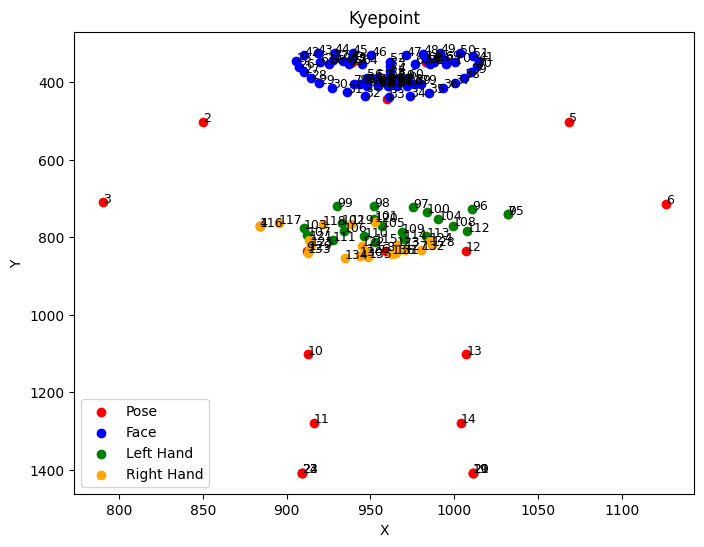

In [6]:
import matplotlib.pyplot as plt

# concated_coords: shape (1, num_points, 2)
# 각 부위별 keypoints 리스트의 길이를 저장 (이미 별도로 계산되어 있어야 함)
num_pose = len(pose_coords)
num_face = len(face_coords)
num_left = len(left_coords)
num_right = len(right_coords)

# 0번째 인덱스로 실제 좌표 추출 (shape: (num_points, 2))
points = concated_coords[0]

# 각 부위별 인덱스 범위 설정
pose_idx = range(0, num_pose)
face_idx = range(num_pose, num_pose + num_face)
left_idx = range(num_pose + num_face, num_pose + num_face + num_left)
right_idx = range(num_pose + num_face + num_left, num_pose + num_face + num_left + num_right)

plt.figure(figsize=(8, 6))

# Pose keypoints (빨간색)
plt.scatter(points[[*pose_idx], 0], points[[*pose_idx], 1], c='red', label='Pose')
for i in pose_idx:
    plt.text(points[i, 0], points[i, 1], str(i), fontsize=9, color='black')

# Face keypoints (파란색)
plt.scatter(points[[*face_idx], 0], points[[*face_idx], 1], c='blue', label='Face')
for i in face_idx:
    plt.text(points[i, 0], points[i, 1], str(i), fontsize=9, color='black')

# Left hand keypoints (초록색)
plt.scatter(points[[*left_idx], 0], points[[*left_idx], 1], c='green', label='Left Hand')
for i in left_idx:
    plt.text(points[i, 0], points[i, 1], str(i), fontsize=9, color='black')

# Right hand keypoints (주황색)
plt.scatter(points[[*right_idx], 0], points[[*right_idx], 1], c='orange', label='Right Hand')
for i in right_idx:
    plt.text(points[i, 0], points[i, 1], str(i), fontsize=9, color='black')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Kyepoint')
plt.legend()
plt.gca().invert_yaxis()  # 이미지 좌표계의 경우 Y축 반전 (필요시)
plt.show()


최종 좌표 배열 shape: (133, 2)


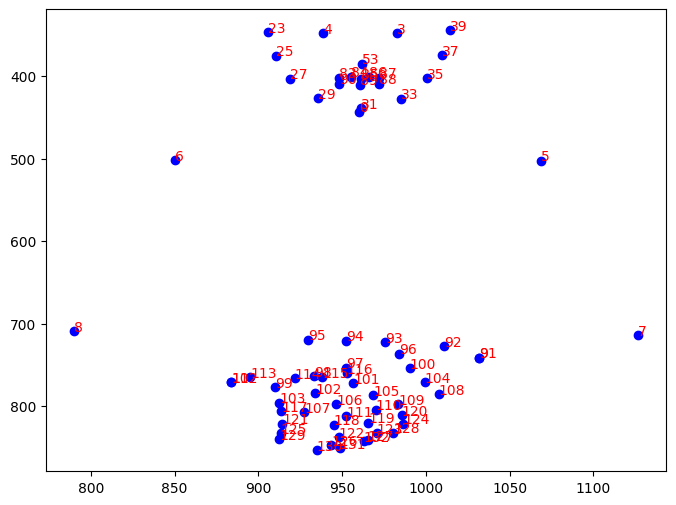

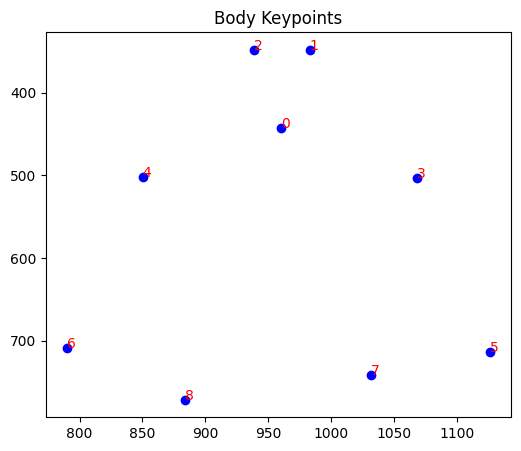

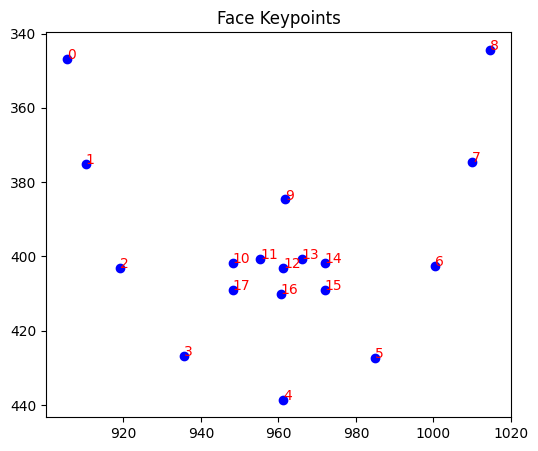

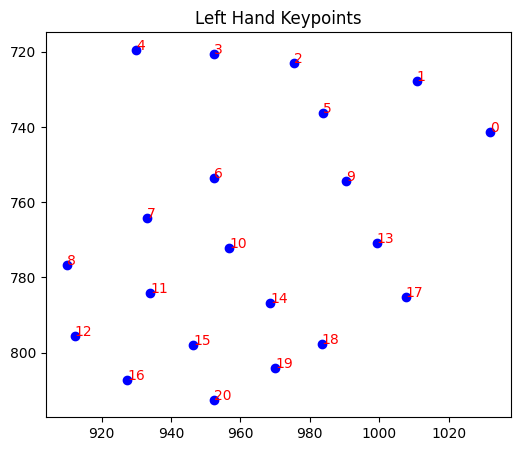

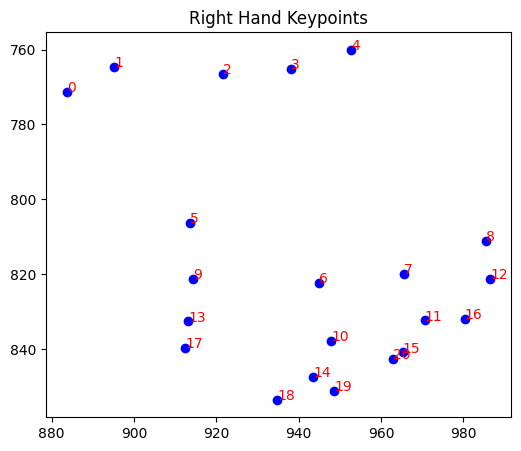

In [21]:
import numpy as np

# 이미 분리된 좌표 리스트가 있다고 가정 (각각 list of [x,y])
# 예: pose_coords, face_coords, left_coords, right_coords

# 원하는 인덱스 (순서 그대로 사용)
# body (여기서는 pose_coords를 body로 사용): 
#   "1 / 16 15 / 5 2 / 6 3 / 7 4" → [1, 16, 15, 5, 2, 6, 3, 7, 4]
body_indices = [1, 16, 15, 5, 2, 6, 3, 7, 4]

# face: "0 2 4 6 8 10 12 14 16 / 30 / 49 50 51 52 53 55 57 59"
face_indices = [0, 2, 4, 6, 8, 10, 12, 14, 16, 30, 49, 50, 51, 52, 53, 55, 57, 59]

# left hand: use all indices
left_indices = list(range(len(left_coords)))

# right hand: use all indices
right_indices = list(range(len(right_coords)))

# 각각 numpy array로 변환 (이미 2차원 [num_points,2] 형태라고 가정)
pose_coords_arr = np.array(pose_coords)
face_coords_arr = np.array(face_coords)
left_coords_arr = np.array(left_coords)
right_coords_arr = np.array(right_coords)

# 원하는 인덱스만 추출 (인덱스 순서를 그대로 유지)
body_subset = pose_coords_arr[body_indices, :]      # body 좌표 추출
face_subset = face_coords_arr[face_indices, :]        # face 좌표 추출
left_subset = left_coords_arr[left_indices, :]        # left hand: 전부 사용
right_subset = right_coords_arr[right_indices, :]     # right hand: 전부 사용

final_len = 133
dummy_value = 0.5

# 최종 좌표 배열 생성 (133 x 2), 기본값 [0.5, 0.5]로 채움
final_coords = np.full((final_len, 2), dummy_value, dtype=np.float32)

# 최종 배열에 넣을 인덱스 (0-indexed)
body_final_positions  = np.array([0, 3, 4, 5, 6, 7, 8, 9, 10])
face_final_positions  = np.array([23, 25, 27, 29, 31, 33, 35, 37, 39, 53, 83, 84, 85, 86, 87, 88, 89, 90])
left_final_positions  = np.arange(91, 112)   # 91 ~ 111 (21개)
right_final_positions = np.arange(112, 133)  # 112 ~ 132 (21개)

# 각 부위의 subset을 지정된 위치에 할당
final_coords[body_final_positions]  = body_subset   # shape: (9, 2)
final_coords[face_final_positions]  = face_subset   # shape: (18, 2)
final_coords[left_final_positions]  = left_subset   # shape: (21, 2)
final_coords[right_final_positions] = right_subset  # shape: (21, 2)

print("최종 좌표 배열 shape:", final_coords.shape)


import matplotlib.pyplot as plt
import numpy as np

# dummy padding 값
dummy_value = 0.5

plt.figure(figsize=(8, 6))
# 최종 좌표(final_coords)의 각 행에 대해 dummy padding이 아닌 부분만 plot
for idx, coord in enumerate(final_coords):
    # 좌표가 [0.5, 0.5]와 동일하면 dummy padding으로 간주
    if not (np.allclose(coord, [dummy_value, dummy_value])):
        plt.scatter(coord[0], coord[1], color='blue', marker='o')
        plt.text(coord[0], coord[1], str(idx), fontsize=10, color='red')

plt.gca().invert_yaxis()  # 이미지 좌표계라면 Y축 반전
plt.show()


plt.figure(figsize=(6, 5))
for local_idx, final_idx in enumerate(body_final_positions):
    coord = final_coords[final_idx]
    plt.scatter(coord[0], coord[1], color='blue')
    plt.text(coord[0], coord[1], str(local_idx), fontsize=10, color='red')
plt.title("Body Keypoints")
plt.gca().invert_yaxis()  # 필요시 Y축 반전
plt.show()

# (2) Face Keypoints
plt.figure(figsize=(6, 5))
for local_idx, final_idx in enumerate(face_final_positions):
    coord = final_coords[final_idx]
    plt.scatter(coord[0], coord[1], color='blue')
    plt.text(coord[0], coord[1], str(local_idx), fontsize=10, color='red')
plt.title("Face Keypoints")
plt.gca().invert_yaxis()
plt.show()

# (3) Left Hand Keypoints
plt.figure(figsize=(6, 5))
for local_idx, final_idx in enumerate(left_final_positions):
    coord = final_coords[final_idx]
    plt.scatter(coord[0], coord[1], color='blue')
    plt.text(coord[0], coord[1], str(local_idx), fontsize=10, color='red')
plt.title("Left Hand Keypoints")
plt.gca().invert_yaxis()
plt.show()

# (4) Right Hand Keypoints
plt.figure(figsize=(6, 5))
for local_idx, final_idx in enumerate(right_final_positions):
    coord = final_coords[final_idx]
    plt.scatter(coord[0], coord[1], color='blue')
    plt.text(coord[0], coord[1], str(local_idx), fontsize=10, color='red')
plt.title("Right Hand Keypoints")
plt.gca().invert_yaxis()
plt.show()

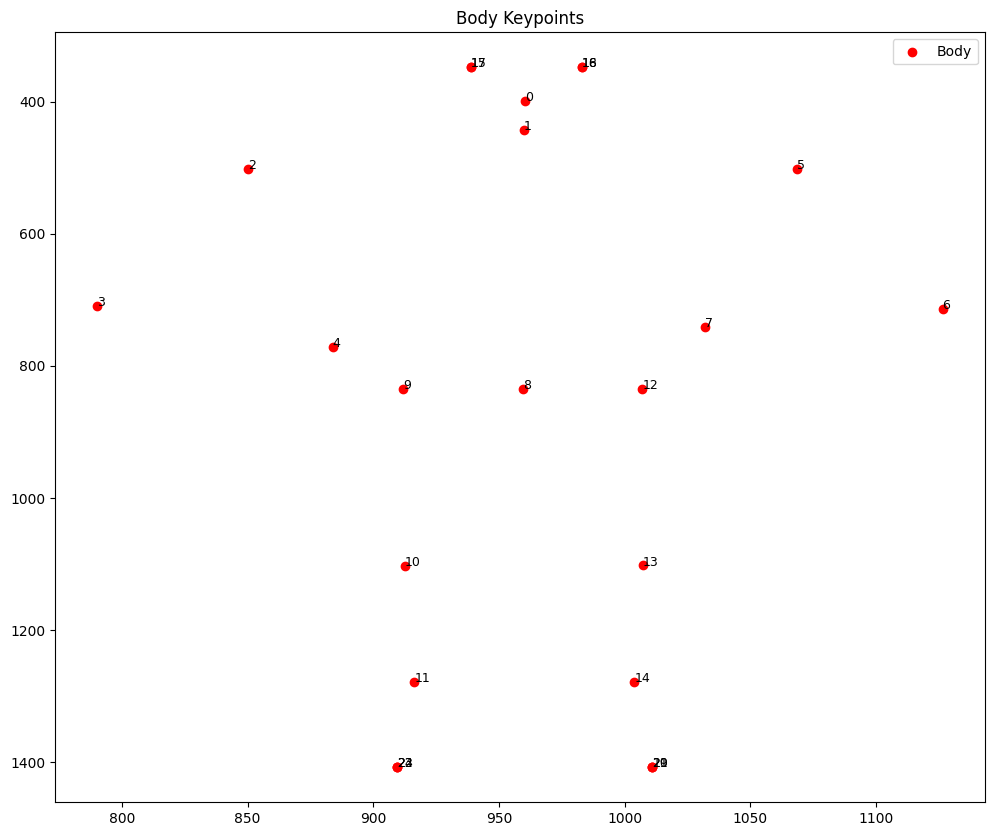

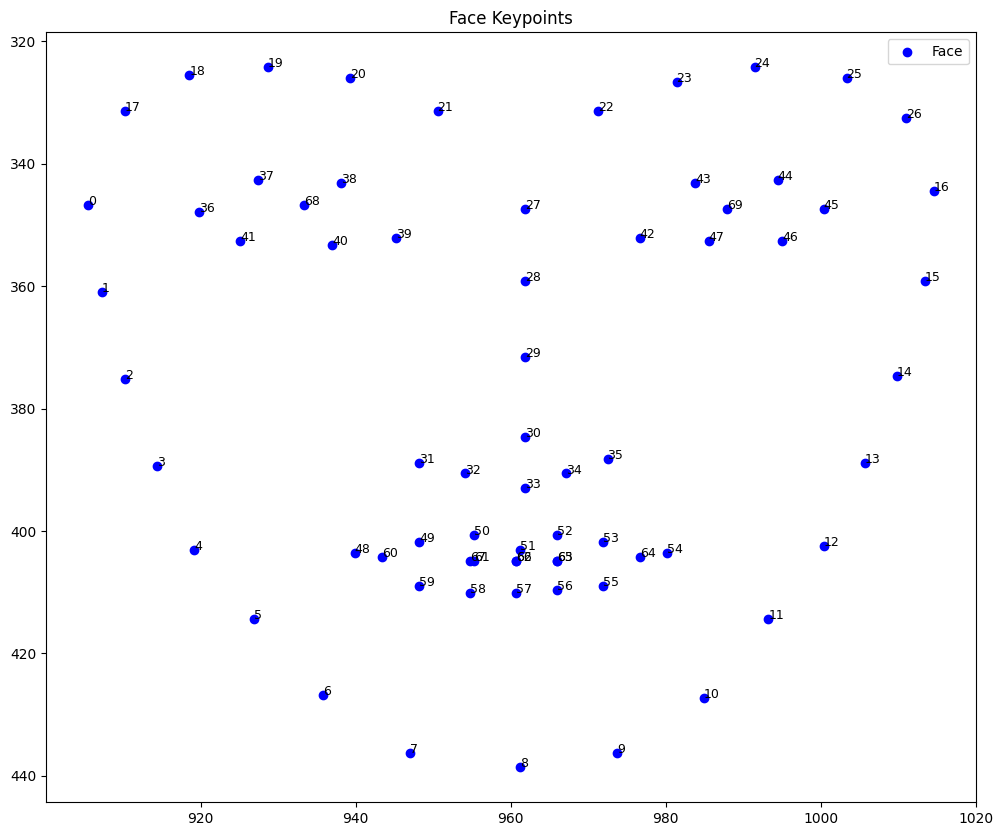

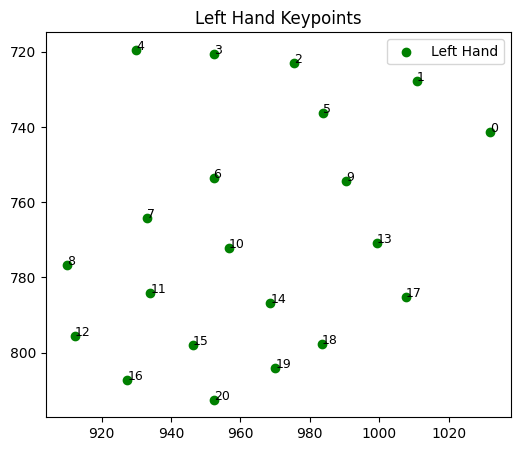

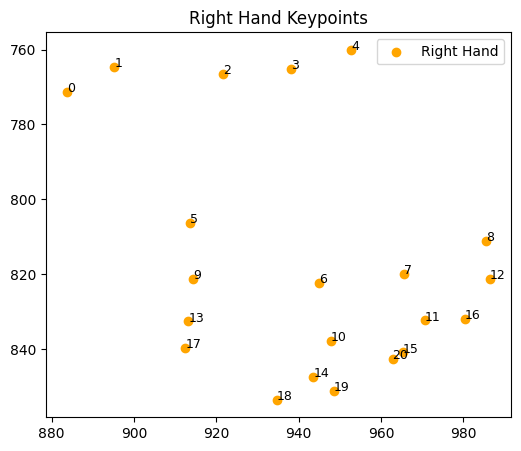

In [12]:
import matplotlib.pyplot as plt

# concated_coords: shape (1, total_points, 2)에서 실제 좌표 배열 추출
points = concated_coords[0]

# 각 부위별 keypoints 개수 (이미 이전 코드에서 계산된 변수 사용)
num_body     = len(pose_coords)       # 기존의 pose가 body 역할
num_face     = len(face_coords)
num_lefthand = len(left_coords)
num_righthand= len(right_coords)

# 인덱스 범위 (concated_coords의 원래 인덱스)
body_range      = range(0, num_body)
face_range      = range(num_body, num_body + num_face)
lefthand_range  = range(num_body + num_face, num_body + num_face + num_lefthand)
righthand_range = range(num_body + num_face + num_lefthand, num_body + num_face + num_lefthand + num_righthand)

# Body keypoints 플롯 (번호는 0부터 시작)
plt.figure(figsize=(12, 10))
plt.scatter(points[list(body_range), 0], points[list(body_range), 1], c='red', label='Body')
for local_idx, global_idx in enumerate(body_range):
    plt.text(points[global_idx, 0], points[global_idx, 1], str(local_idx), fontsize=9, color='black')
plt.title('Body Keypoints')
plt.legend()
plt.gca().invert_yaxis()  # 필요시 Y축 반전
plt.show()

# Face keypoints 플롯
plt.figure(figsize=(12, 10))
plt.scatter(points[list(face_range), 0], points[list(face_range), 1], c='blue', label='Face')
for local_idx, global_idx in enumerate(face_range):
    plt.text(points[global_idx, 0], points[global_idx, 1], str(local_idx), fontsize=9, color='black')
plt.title('Face Keypoints')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

# Left Hand keypoints 플롯
plt.figure(figsize=(6, 5))
plt.scatter(points[list(lefthand_range), 0], points[list(lefthand_range), 1], c='green', label='Left Hand')
for local_idx, global_idx in enumerate(lefthand_range):
    plt.text(points[global_idx, 0], points[global_idx, 1], str(local_idx), fontsize=9, color='black')
plt.title('Left Hand Keypoints')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

# Right Hand keypoints 플롯
plt.figure(figsize=(6, 5))
plt.scatter(points[list(righthand_range), 0], points[list(righthand_range), 1], c='orange', label='Right Hand')
for local_idx, global_idx in enumerate(righthand_range):
    plt.text(points[global_idx, 0], points[global_idx, 1], str(local_idx), fontsize=9, color='black')
plt.title('Right Hand Keypoints')
plt.legend()
plt.gca().invert_yaxis()
plt.show()
